## **Exploratory Data Analysis of Crops and Environmental Conditions Dataset**
### **Outline of Process:**
1) Load and inspect data from database
   * To import data from database for analysist
   * To get an overview of the dataset's structure, size, missing values, type of variables (numerical or categorical) and their data types.

2) Ouality Check
   * To check dataset for incorrect data type, missing values, duplicated entries, inconsistent naming (categorical variables) and other typos.
   * Numerical variables which are in string data type are corrected and converted to integer/floats.
   * Negative values in numerical variables which shouldn't be negative are replaced with their medians.
   * Rows with missing values in any of the columns are deleted. There is no missing value in the categorical variables of this dataset.
   * Categorical variables with inconsistent naming are corrected and standardised.
   * Duplicated rows are deleted from the dataset.

3) Feature Engineering
   * To create additional feature (if neccessary) from existing ones (e.g Plant Type-Stage from Plant Type and Plant Stage)

4) Descriptive Statistics
   * Numerical variable:
     * Generate descriptive statistics.
     * Explore distribution
   * Categorical variable:
     * Explore distribution

5) Explore relationship between numerical variables.
   * Compute correlation. Highly correlated variables can be removed.

6) Explore the relationship between Plant Type-Stage (Y variable) and the other features (X variables)
   * Graphical visualization (e.g Boxplot, stacked barcharts)
   * Statistical test (e.g Chi Square test of independence)
    
7) Explore the relationship between Temperature (Y variable) and the other features (X variables)
   * Graphical visualization (e.g Boxplot)

### **Assumption**:
### Since the farm is a closed and controlled environment (as stated in the question), it is reasonable to assume that temperature cannot be negative.

In [3]:
# Import required libraries.
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [4]:
# Function for renaming plant type.
def rename_plantType(x):
    if x in ['VINE CROPS','vine crops']:
        return 'Vine Crops'
    if x in ['herbs','HERBS']:
        return 'Herbs'
    if x in ['fruiting vegetables','FRUITING VEGETABLES']:
        return 'Fruiting Vegetables'
    if x in ['LEAFY GREENS','leafy greens']:
        return 'Leafy Greens'
    else:
        return x

In [5]:
# Function for renaming plant stage.
def rename_plantStage(x):
    if x in ['maturity','MATURITY']:
        return 'Maturity'
    if x in ['vegetative','VEGETATIVE']:
        return 'Vegetative'
    if x in ['seedling','SEEDLING']:
        return 'Seedling'
    else:
        return x

In [6]:
# Function for tabulating the raw counts and %counts of plant type-stage across categorical variables.
def cross_table(series1, series2):
    xtable = pd.crosstab(series1, series2)
    cols = xtable.columns.to_list()
    
    xtable['Total'] = xtable[cols].sum(axis=1)
    
    for f in cols:
        xtable[f+'(%)'] = (xtable[f]/xtable['Total'])*100

    return xtable

In [7]:
# Function for plotting stacked barchart to visualize the breakdown of plant type-stage across categorical variables.
def stackBar(df, xlabel, ylabel, title, normalized=True):
    if normalized:
        df.iloc[:,0:12].plot(kind='bar', stacked=True)
    else:
        df.iloc[:,13:].plot(kind='bar', stacked=True)
        
    plt.xlabel(xlabel, fontsize=10)
    plt.xticks(fontsize=10)
    plt.ylabel(ylabel, fontsize=10)
    plt.yticks(fontsize=10)
    plt.title(title, fontsize=10, y=1.05)
    plt.xticks(rotation=90)
    plt.legend(prop=dict(size=10), loc='upper right', bbox_to_anchor=(1.6, 1))
    plt.show()

In [8]:
# Function for plotting barchart to visualize the distribution of catergorical variables.
def barchart(series, xlabel, ylabel, title):
    plant_type_stage = series.value_counts(normalize=False).sort_index()
    plt.bar(plant_type_stage.index, plant_type_stage.values)
    plt.xlabel(xlabel, fontsize=10)
    plt.xticks(fontsize=10)
    plt.ylabel(ylabel, fontsize=10)
    plt.yticks(fontsize=10)
    plt.title(title, fontsize=15, y=1.05)
    plt.xticks(rotation=90)
    plt.show()

In [9]:
# Functions for plotting histograms to visualize disribution of numerical variables.
def histogram(df, start, end, title):
    
    fig, ax = plt.subplots(4,3, figsize=(25,20))

    r, c, i = 0, 0, 0
    
    colors = ['blue','orange','red','grey','green','yellow','brown','black','purple','cyan','olive','pink']
    plt.style.use('default')
    
    for f in df.columns[start:end]:
        
        x = df[f]
        
        ax[r,c].hist(x, bins=8, density=False, color=colors[i], alpha=0.7, edgecolor='black')
        ax[r,c].set_ylabel('Frequency', fontdict={'fontsize':20})
        ax[r,c].set_xlabel(f, fontdict={'fontsize':20})
        ax[r,c].tick_params(axis='both', labelsize=20)
        ax[r,c].set_title(f.split()[0], fontdict={'fontsize':20})
        i+=1
        if c>1:
            r+=1
            c=0
        else:
            c+=1
    
    plt.suptitle(title, fontsize=40, y=1.05)    
    fig.tight_layout(h_pad=3)
    plt.show()

In [10]:
# Functions for drawing heatmap to visualize correlation.
def correlation_heatmap(df):
    correlation = df.select_dtypes(exclude='object').corr('spearman')
    plt.figure(figsize = (12,10))
    plt.rcParams.update({'font.size': 9})
    sns.heatmap(correlation, cmap = 'coolwarm', vmin = -1, vmax = 1, center = 0, annot=True, fmt=".3f", square=True, linewidths=.5)
    plt.show()

### 1. **Data Loading & Inspection**
The purpose of this step are as follow:
1) To load data from database.
2) Get an overview of the dataset.

**1.1 Load data from database**

In [13]:
# Connect and read database into pandas dataframe.
con = sqlite3.connect("data/agri.db") 
agri = pd.read_sql_query("SELECT * from farm_data", con)

**1.2  Overview of dataset**

In [15]:
# Overview of the dataset.
agri.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57489 entries, 0 to 57488
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   System Location Code          57489 non-null  object 
 1   Previous Cycle Plant Type     57489 non-null  object 
 2   Plant Type                    57489 non-null  object 
 3   Plant Stage                   57489 non-null  object 
 4   Temperature Sensor (°C)       48800 non-null  float64
 5   Humidity Sensor (%)           18622 non-null  float64
 6   Light Intensity Sensor (lux)  53211 non-null  float64
 7   CO2 Sensor (ppm)              57489 non-null  int64  
 8   EC Sensor (dS/m)              57489 non-null  float64
 9   O2 Sensor (ppm)               57489 non-null  int64  
 10  Nutrient N Sensor (ppm)       47515 non-null  object 
 11  Nutrient P Sensor (ppm)       51791 non-null  object 
 12  Nutrient K Sensor (ppm)       53788 non-null  object 
 13  p

The dataset has 15 columns and 57489 rows. There are 4 categorical variables, The rest are numerical variables. Some numerical variables (Nutrient N Sensor,  Nutrient P Sensor and  Nutrient K Sensor) are in string data type. They need to be converted to float or integer. There are many missing values.

### 2. **Data Cleaning & Processing**
The purpose of this step are as following:
1) Check for and resolve inconsistent entries (e.g different naming of the same plant types & plant stages)
2) To convert variables into their correct datatypes.
3) Check for and remove duplicate entries.
4) Check for possible error entries (e.g. negative values for variables that can only have positive values)
5) Create new feature 'Plant Type-Stage' from existing 'Plant Type' and 'Plant Stage' features.
6) Check for and drop away missing values.

**2.1 Check for and resolve inconsistent entries**

In [19]:
# Check the unique classes of the 4 categorical variables.
print(agri['System Location Code'].unique())
print(agri['Previous Cycle Plant Type'].unique())
print(agri['Plant Type'].unique())
print(agri['Plant Stage'].unique())

['Zone_D' 'Zone_G' 'Zone_F' 'Zone_B' 'Zone_C' 'Zone_A' 'Zone_E']
['Herbs' 'Vine Crops' 'Leafy Greens' 'Fruiting Vegetables']
['Vine Crops' 'VINE CROPS' 'herbs' 'fruiting vegetables' 'LEAFY GREENS'
 'FRUITING VEGETABLES' 'Leafy Greens' 'Herbs' 'Fruiting Vegetables'
 'HERBS' 'vine crops' 'leafy greens']
['Maturity' 'Vegetative' 'maturity' 'seedling' 'MATURITY' 'Seedling'
 'SEEDLING' 'VEGETATIVE' 'vegetative']


In [20]:
# Apply functions to rename Plant Type and Plant Stage classes.
agri['Plant Type'] = agri['Plant Type'].apply(rename_plantType)
agri['Plant Stage'] = agri['Plant Stage'].apply(rename_plantStage)

In [21]:
print(agri['System Location Code'].unique())
print(agri['Previous Cycle Plant Type'].unique())
print(agri['Plant Type'].unique())
print(agri['Plant Stage'].unique())

['Zone_D' 'Zone_G' 'Zone_F' 'Zone_B' 'Zone_C' 'Zone_A' 'Zone_E']
['Herbs' 'Vine Crops' 'Leafy Greens' 'Fruiting Vegetables']
['Vine Crops' 'Herbs' 'Fruiting Vegetables' 'Leafy Greens']
['Maturity' 'Vegetative' 'Seedling']


Plant Type and Plant Stage variables have more than 1 unique label for the same type and stage, arising from the inconsistent use of uppercase and lowercase letters in naming. This problem is resolved by renaming the plant types and stages, resulting in 1 unique label for each unique plant type and stage. The numbers of plant type and stage are reduced from 12 and 9 to 4 and 3 respectively.

**2.2 Convert variables into their correct datatypes**

In [24]:
# Check entries of Nutrient P Sensor (ppm).
agri['Nutrient P Sensor (ppm)'].unique()

array(['64', '53', '79', '53 ppm', '19', '62', None, '70', '52', '55',
       '20', '50', '72', '26', '41', '32', '60', '63', '37', '80', '47',
       '23', '22', '74', '28', '34', '50 ppm', '69', '76', '68', '27',
       '75', '54', '77', '46', '66', '57', '61', '71', '58', '45', '48',
       '36', '65', '56', '51', '67', '44', '30', '43', '40', '73', '33',
       '35', '42', '31', '24', '39', '59', '38', '49', '21', '78', '25',
       '29', '64 ppm', '73 ppm', '56 ppm', '65 ppm', '34 ppm', '61 ppm',
       '63 ppm', '33 ppm', '71 ppm', '29 ppm', '54 ppm', '43 ppm',
       '77 ppm', '31 ppm', '66 ppm', '36 ppm', '46 ppm', '52 ppm',
       '68 ppm', '44 ppm', '59 ppm', '76 ppm', '55 ppm', '22 ppm',
       '67 ppm', '39 ppm', '58 ppm', '57 ppm', '24 ppm', '60 ppm',
       '30 ppm', '42 ppm', '38 ppm', '20 ppm', '37 ppm', '49 ppm',
       '75 ppm', '41 ppm', '69 ppm', '47 ppm', '62 ppm', '79 ppm',
       '28 ppm', '21 ppm', '70 ppm', '23 ppm', '35 ppm', '72 ppm',
       '45 ppm', '48 ppm

In [25]:
# To split the strings into number and character parts.Keep only the number parts. Convert the number parts to float.
for f in agri.loc[:, agri.columns.str.contains('Nutrient')].columns:
    agri[f] = agri[f].apply(lambda x: float(x.split()[0]) if x is not None else x)

In [26]:
# Check entries of Nutrient P Sensor (ppm) after correction.
agri['Nutrient P Sensor (ppm)'].unique()

array([64., 53., 79., 19., 62., nan, 70., 52., 55., 20., 50., 72., 26.,
       41., 32., 60., 63., 37., 80., 47., 23., 22., 74., 28., 34., 69.,
       76., 68., 27., 75., 54., 77., 46., 66., 57., 61., 71., 58., 45.,
       48., 36., 65., 56., 51., 67., 44., 30., 43., 40., 73., 33., 35.,
       42., 31., 24., 39., 59., 38., 49., 21., 78., 25., 29.])

Nutrient N Sensor, Nutrient P Sensor and Nutrient K Sensor are numerical variables. But, their entries are in string data type. Some of the strings have both the number and 'ppm'parts. Before the strings can be converted to float, the characters 'ppm' part needs to be removed. The number parts of the strings are then converted to float.

In [28]:
agri.fillna(value=pd.NA, inplace=True)

**2.3 Check for and remove duplicate entries.**

In [30]:
# Check for dupliated entries in dataframe.
agri.loc[agri.duplicated(keep=False)]

,System Location Code,Previous Cycle Plant Type,Plant Type,Plant Stage,Temperature Sensor (°C),Humidity Sensor (%),Light Intensity Sensor (lux),CO2 Sensor (ppm),EC Sensor (dS/m),O2 Sensor (ppm),Nutrient N Sensor (ppm),Nutrient P Sensor (ppm),Nutrient K Sensor (ppm),pH Sensor,Water Level Sensor (mm)
7,Zone_G,Herbs,Leafy Greens,Maturity,20.16,NaN,317.0,1133,1.52,10,NaN,NaN,277.0,5.8,39.611156
8,Zone_G,Herbs,Leafy Greens,Maturity,20.16,NaN,317.0,1133,1.52,10,NaN,NaN,277.0,5.8,39.611156
14,Zone_B,Herbs,Fruiting Vegetables,Maturity,24.50,NaN,664.0,1438,2.22,7,238.0,72.0,251.0,6.3,22.530938
15,Zone_B,Herbs,Fruiting Vegetables,Maturity,24.50,NaN,664.0,1438,2.22,7,238.0,72.0,251.0,6.3,22.530938
28,Zone_C,Leafy Greens,Leafy Greens,Vegetative,21.88,65.62,387.0,1007,0.86,5,115.0,32.0,NaN,6.3,20.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57468,Zone_A,Leafy Greens,Leafy Greens,Vegetative,19.70,68.16,NaN,1198,1.75,5,179.0,NaN,261.0,6.2,20.000000
57476,Zone_A,Fruiting Vegetables,Fruiting Vegetables,Vegetative,22.82,NaN,772.0,1258,0.75,7,213.0,74.0,213.0,5.8,25.124531
57477,Zone_A,Fruiting Vegetables,Fruiting Vegetables,Vegetative,22.82,NaN,772.0,1258,0.75,7,213.0,74.0,213.0,5.8,25.124531
57484,Zone_C,Vine Crops,Fruiting Vegetables,Maturity,NaN,NaN,619.0,1074,1.95,6,150.0,61.0,210.0,6.4,NaN


In [31]:
# Drop dulipcates and keep only the first one.
agri.drop_duplicates(keep='first',ignore_index=True, inplace=True)
agri.loc[agri.duplicated()]

,System Location Code,Previous Cycle Plant Type,Plant Type,Plant Stage,Temperature Sensor (°C),Humidity Sensor (%),Light Intensity Sensor (lux),CO2 Sensor (ppm),EC Sensor (dS/m),O2 Sensor (ppm),Nutrient N Sensor (ppm),Nutrient P Sensor (ppm),Nutrient K Sensor (ppm),pH Sensor,Water Level Sensor (mm)


Duplicated rows are found in the dataset. Presence of duplicates introduces distortion that can affect ML modelling results. All duplicates in the dataframes are dropped. It is verified that there is no duplicate in the dataframe.

**2.4 Check for possible error entries**

In [34]:
# Descriptive statistics to detect possible peculiar entries.
agri.select_dtypes(exclude='object').describe().T

,count,mean,std,min,25%,50%,75%,max
Temperature Sensor (°C),42416.0,22.161807,7.483871,-28.570000,22.140000,23.21,24.35,28.750000
Humidity Sensor (%),16214.0,69.230421,5.728011,59.220000,64.340000,68.66,74.10,81.140000
Light Intensity Sensor (lux),46276.0,398.339485,222.320399,-799.000000,257.000000,404.00,553.00,800.000000
CO2 Sensor (ppm),50000.0,1083.223440,172.529164,799.000000,950.000000,1071.00,1178.00,1500.000000
EC Sensor (dS/m),50000.0,1.624247,0.415122,-0.250000,1.360000,1.65,1.90,3.440000
O2 Sensor (ppm),50000.0,6.581000,1.147460,3.000000,6.000000,7.00,7.00,11.000000
Nutrient N Sensor (ppm),41328.0,157.768849,45.632916,49.000000,124.000000,158.00,190.00,250.000000
Nutrient P Sensor (ppm),45042.0,49.865526,15.416017,19.000000,37.000000,50.00,62.00,80.000000
Nutrient K Sensor (ppm),46781.0,218.062696,60.723034,99.000000,170.000000,215.00,266.00,350.000000
pH Sensor,50000.0,6.021598,0.400561,3.800000,5.800000,6.00,6.30,7.800000


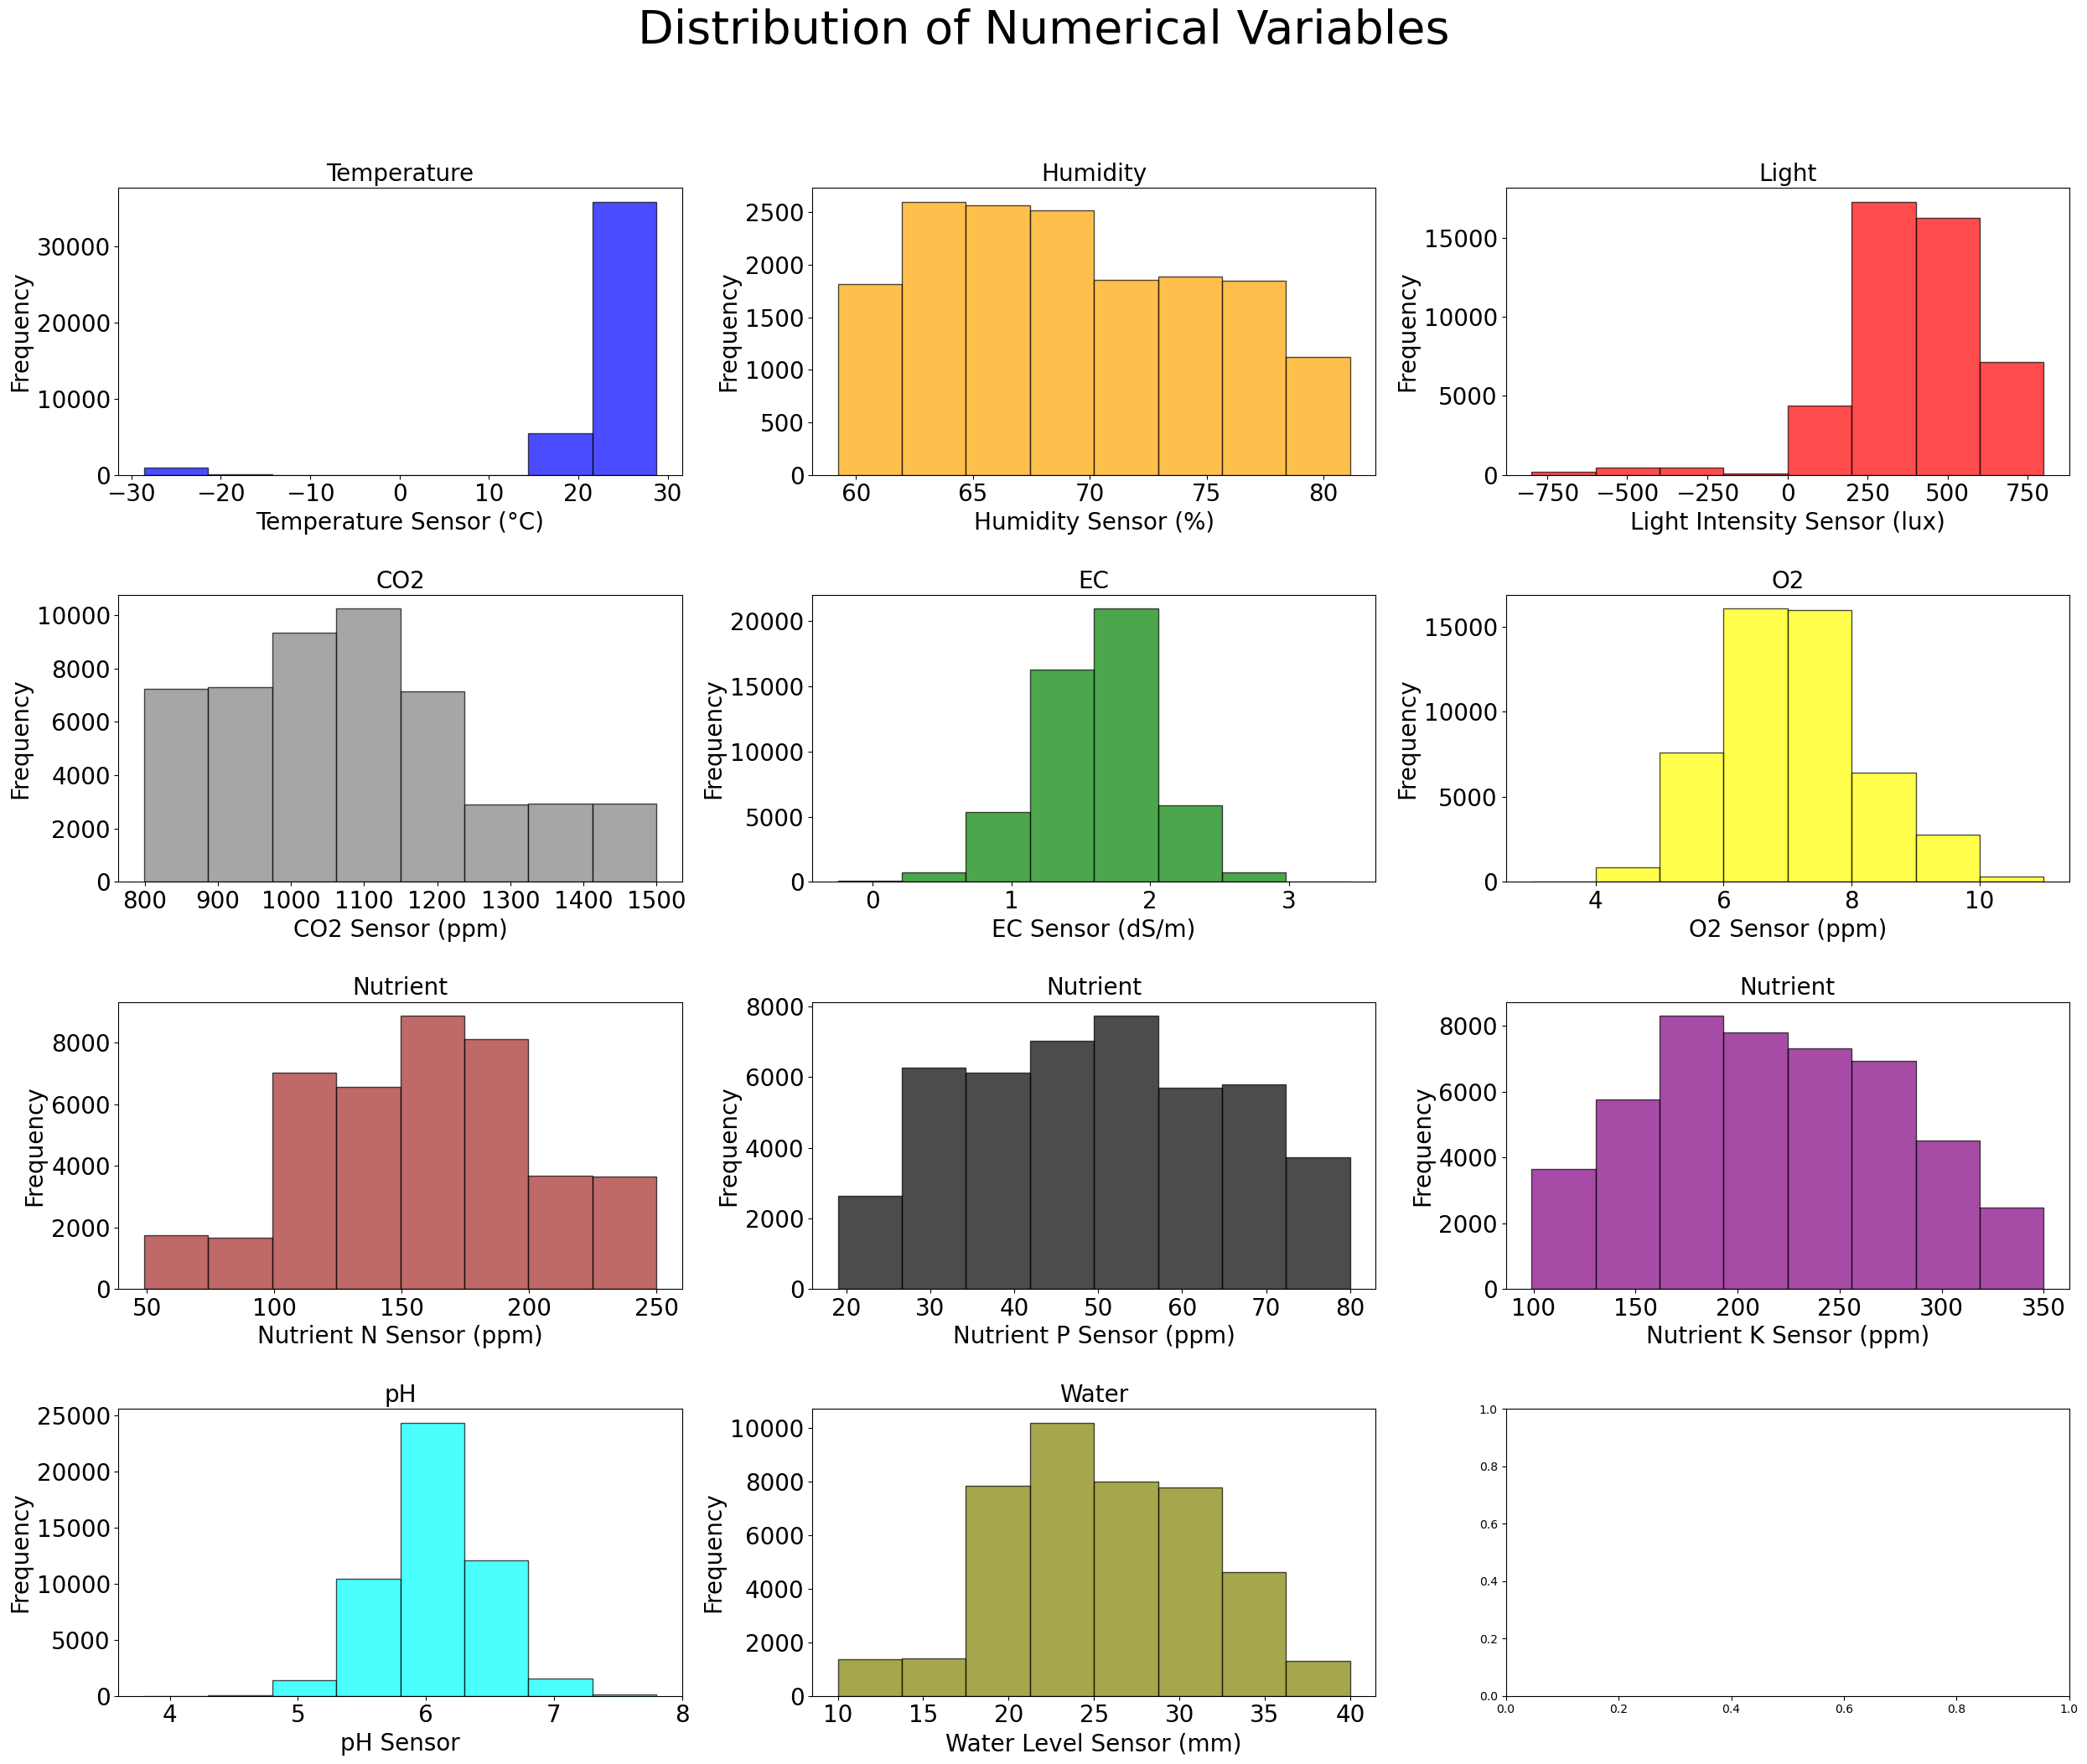

In [35]:
# Look at the frequency and distribution of the negative values.
histogram(agri, 4, 15, 'Distribution of Numerical Variables')

In [36]:
# Replace the negative values with the medians of the variables.
agri.loc[agri['Temperature Sensor (°C)']<0, 'Temperature Sensor (°C)'] = agri['Temperature Sensor (°C)'].median()
agri.loc[agri['Light Intensity Sensor (lux)']<0, 'Light Intensity Sensor (lux)'] = agri['Light Intensity Sensor (lux)'].median()
agri.loc[agri['EC Sensor (dS/m)']<0, 'EC Sensor (dS/m)'] = agri['EC Sensor (dS/m)'].median()

Descriptive statistics of the raw dataset show that Temperature, Light Intensity and EC Senors have negative values. Since the farm is a closed and controlled environment, it is assumed that temperature cannot be negatives. Light intensity and EC are phenomenon that cannot be negative. Based on the distribution of the 3 variables, it appears that the negative values are low frequency outliers. Hence, these negative values are replaced by the medians of the variables.

**2.5 Create new feature 'Plant Type-Stage'**

In [39]:
# Create Plant Type-Stage feature from Plant Type and Plant Stage.
agri['Plant Type-Stage'] = agri['Plant Type'] + '-' + agri['Plant Stage']

**2.6 Check for and drop missing values**

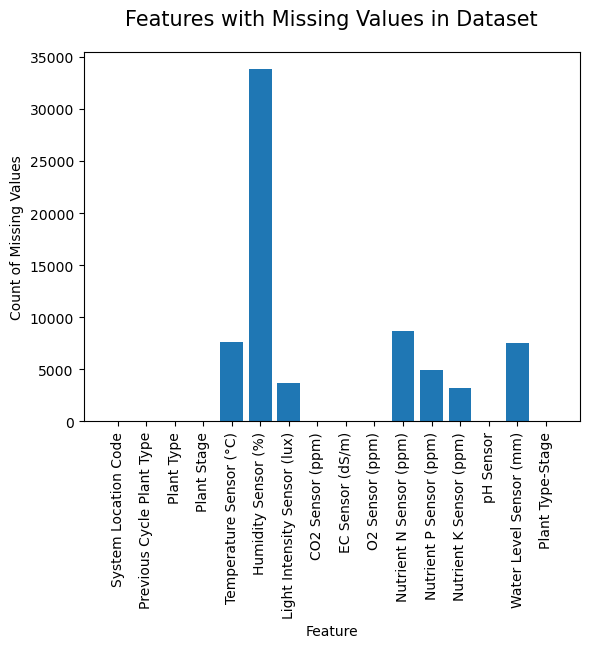

In [41]:
# Identify which features have missing values in the dataset.
plt.bar(agri.isnull().sum().index, agri.isnull().sum().values)
plt.xlabel('Feature', fontsize=10)
plt.xticks(fontsize=10)
plt.ylabel('Count of Missing Values', fontsize=10)
plt.yticks(fontsize=10)
plt.title("Features with Missing Values in Dataset", fontsize=15, y=1.05)
plt.xticks(rotation=90)
plt.show()

In [42]:
# Drop rows with missing values.
agri.dropna(inplace=True, ignore_index=True)

Since more than 50% of the rows have missing values in Humidity, it would not be accurate to fill them with statistics derived from the smaller pool of humidity values. Hence, these rows are dropped. Rows with missing values in the other variables are also dropped together. 

In [44]:
# Final cleaned and processed dataset.
agri.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7413 entries, 0 to 7412
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   System Location Code          7413 non-null   object 
 1   Previous Cycle Plant Type     7413 non-null   object 
 2   Plant Type                    7413 non-null   object 
 3   Plant Stage                   7413 non-null   object 
 4   Temperature Sensor (°C)       7413 non-null   float64
 5   Humidity Sensor (%)           7413 non-null   float64
 6   Light Intensity Sensor (lux)  7413 non-null   float64
 7   CO2 Sensor (ppm)              7413 non-null   int64  
 8   EC Sensor (dS/m)              7413 non-null   float64
 9   O2 Sensor (ppm)               7413 non-null   int64  
 10  Nutrient N Sensor (ppm)       7413 non-null   float64
 11  Nutrient P Sensor (ppm)       7413 non-null   float64
 12  Nutrient K Sensor (ppm)       7413 non-null   float64
 13  pH 

### **3. Exploratory Data Analysis**
The purpose of this step are as follow:
1) To understand the features by generating descriptive statistics and distribution of each feature.
2) To determine the correlation between the numerical variables.
3) To explore the relationship (if any) between Plant Type-Stage (Y variable) and the other features (X variables).
4) To explore the relationship (if any) between Temperature (Y variable) and the other features (X variables).

**3.1 Descriptive Statistics and Distribution**

In [47]:
# Descriptive statistics of cleaned dataset.
agri.select_dtypes(exclude='object').describe().T

,count,mean,std,min,25%,50%,75%,max
Temperature Sensor (°C),7413.0,23.322948,1.577075,19.040000,22.280000,23.22,24.28,28.480000
Humidity Sensor (%),7413.0,69.199483,5.732313,59.220000,64.310000,68.63,74.10,81.140000
Light Intensity Sensor (lux),7413.0,417.251180,175.780563,100.000000,265.000000,404.00,551.00,800.000000
CO2 Sensor (ppm),7413.0,1083.370835,172.313949,800.000000,949.000000,1072.00,1180.00,1499.000000
EC Sensor (dS/m),7413.0,1.631310,0.416000,0.010000,1.370000,1.66,1.90,3.320000
O2 Sensor (ppm),7413.0,6.578308,1.147029,4.000000,6.000000,7.00,7.00,10.000000
Nutrient N Sensor (ppm),7413.0,157.872386,45.907779,49.000000,124.000000,158.00,191.00,250.000000
Nutrient P Sensor (ppm),7413.0,49.860920,15.487333,19.000000,37.000000,50.00,62.00,80.000000
Nutrient K Sensor (ppm),7413.0,218.430460,61.207471,99.000000,171.000000,215.00,267.00,350.000000
pH Sensor,7413.0,6.017564,0.400478,4.400000,5.800000,6.00,6.30,7.600000


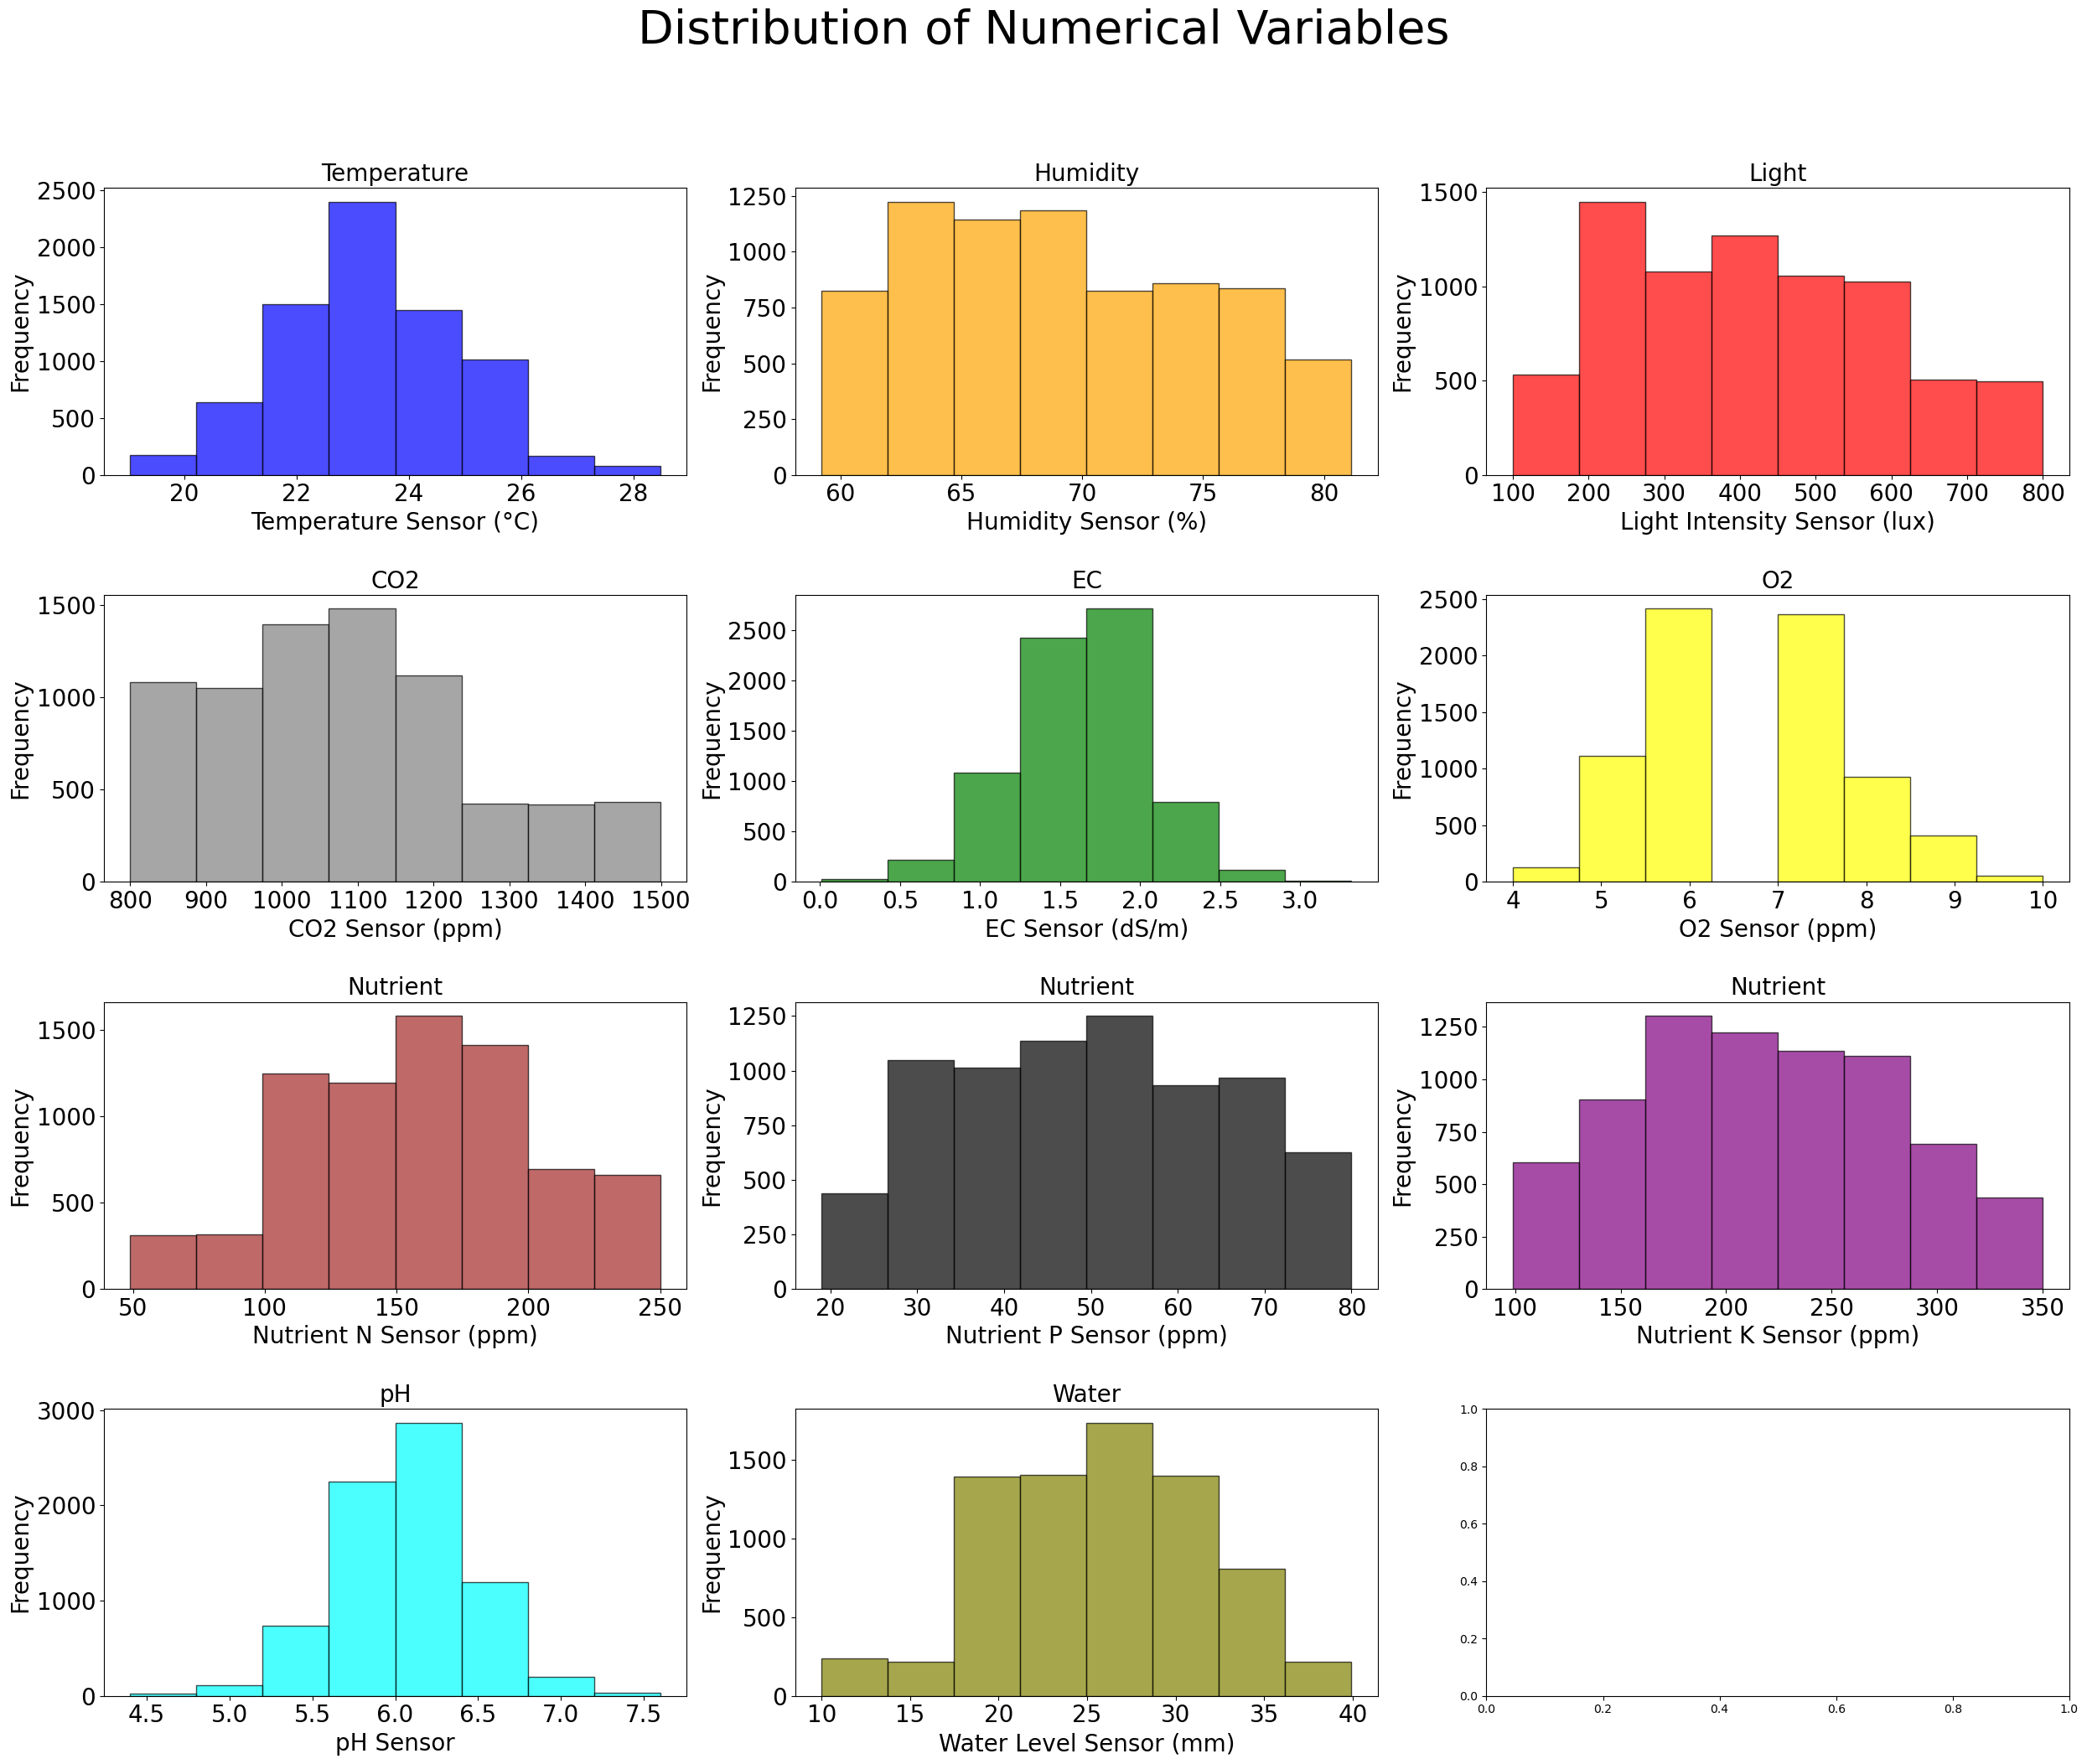

In [48]:
# Distribution of numerical variables in cleaned dataset.
histogram(agri, 4, -1, 'Distribution of Numerical Variables')

Descriptive statistic shows the mean, standard deviation, 25th, 50th (median), 75th percentiles, min and max values of each numerical features of the cleaned and processed dataset. These numbers are visualized with the histograms. Note the disappearance of the negative values from Tempaerature, Light Intensity and EC Sensors. Their distributions become less skewed.

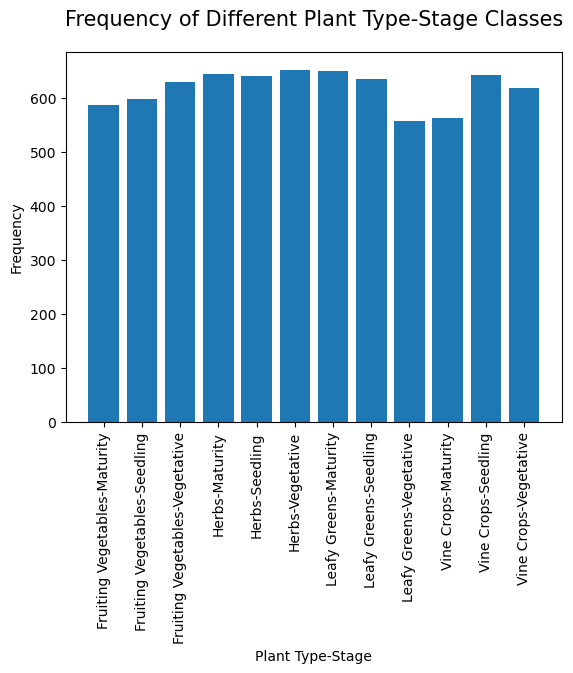

In [50]:
# Distribution of Plant Type-Stage.
barchart(agri['Plant Type-Stage'],'Plant Type-Stage','Frequency','Frequency of Different Plant Type-Stage Classes' )

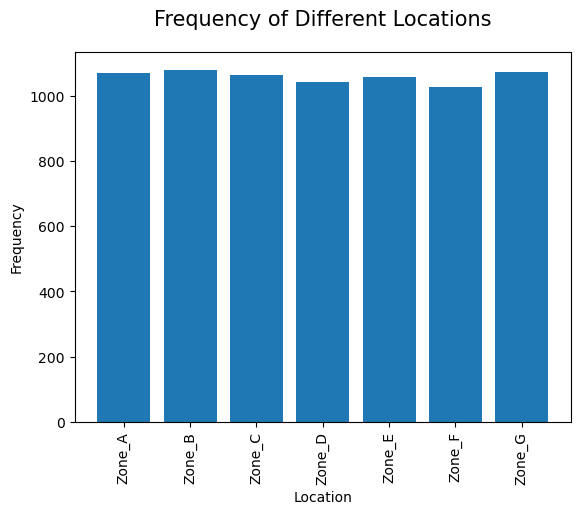

In [51]:
# Distribution of System Location Code.
barchart(agri['System Location Code'],'Location','Frequency','Frequency of Different Locations')

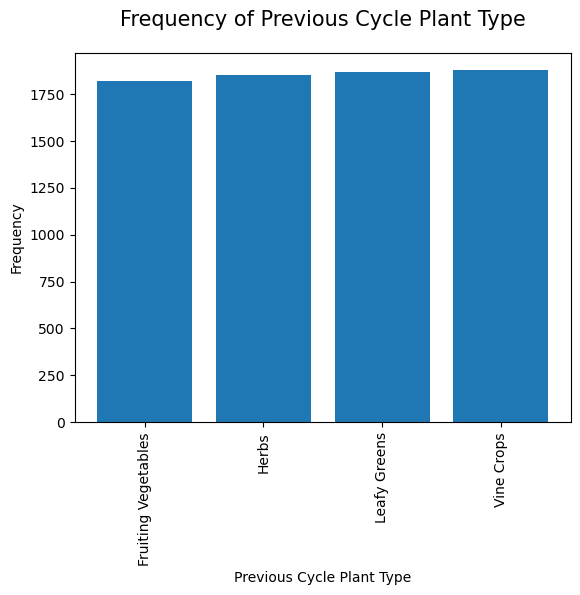

In [52]:
# Distribution of Previous Cycle Plant Type.
barchart(agri['Previous Cycle Plant Type'],'Previous Cycle Plant Type','Frequency','Frequency of Previous Cycle Plant Type')

The different classes of each categorical variable are almost equally distributed. Since Plant type and Plant Stage are combined into Plant Type-Stage, they are not analyzed here.

**3.2 Correlation between numerical variables**

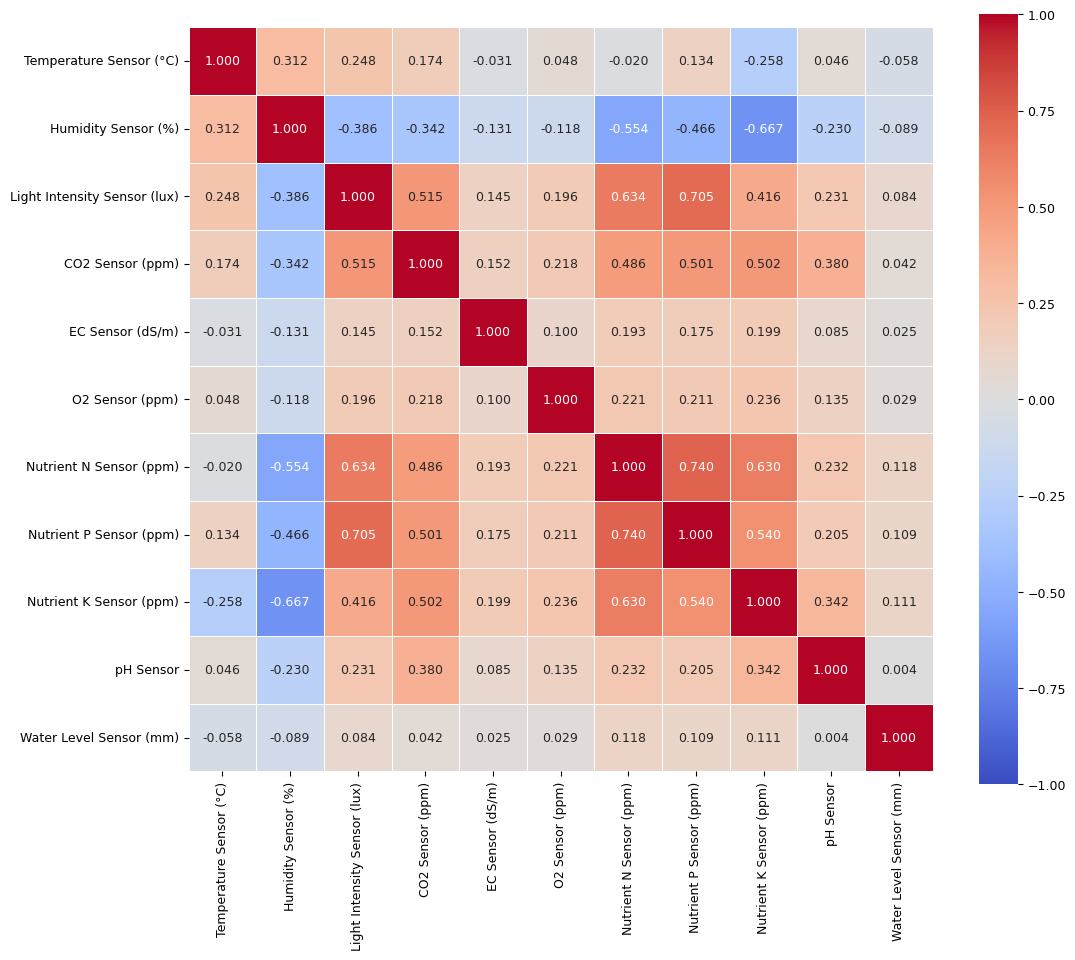

In [55]:
# Determine the correlation between the numerical variables.
correlation_heatmap(agri)

The heatmap above shows that several features are correlated among each other. Temperature is correlated with Humidity, Light Intensity, CO2, Nutrient P and Nutrient K, suggesting that temperature can be predicted from these variables. Humidity, Light Intensity and CO2 are correlated with Nutrient N, Nutrient P and Nutrient K. The 3 Nutrient N, P and K are also correated among themselves. The patterns suggest that some of these variables can be dropped to prevent collinearity, as they may be redundant and add little value to the prediction performance for Temperature and Plant Type-Stage. 

**3.3 Relationship between Plant Type-Stage (Y variable) and the other features (X variables)**

**3.3.1 Numerical X variables**

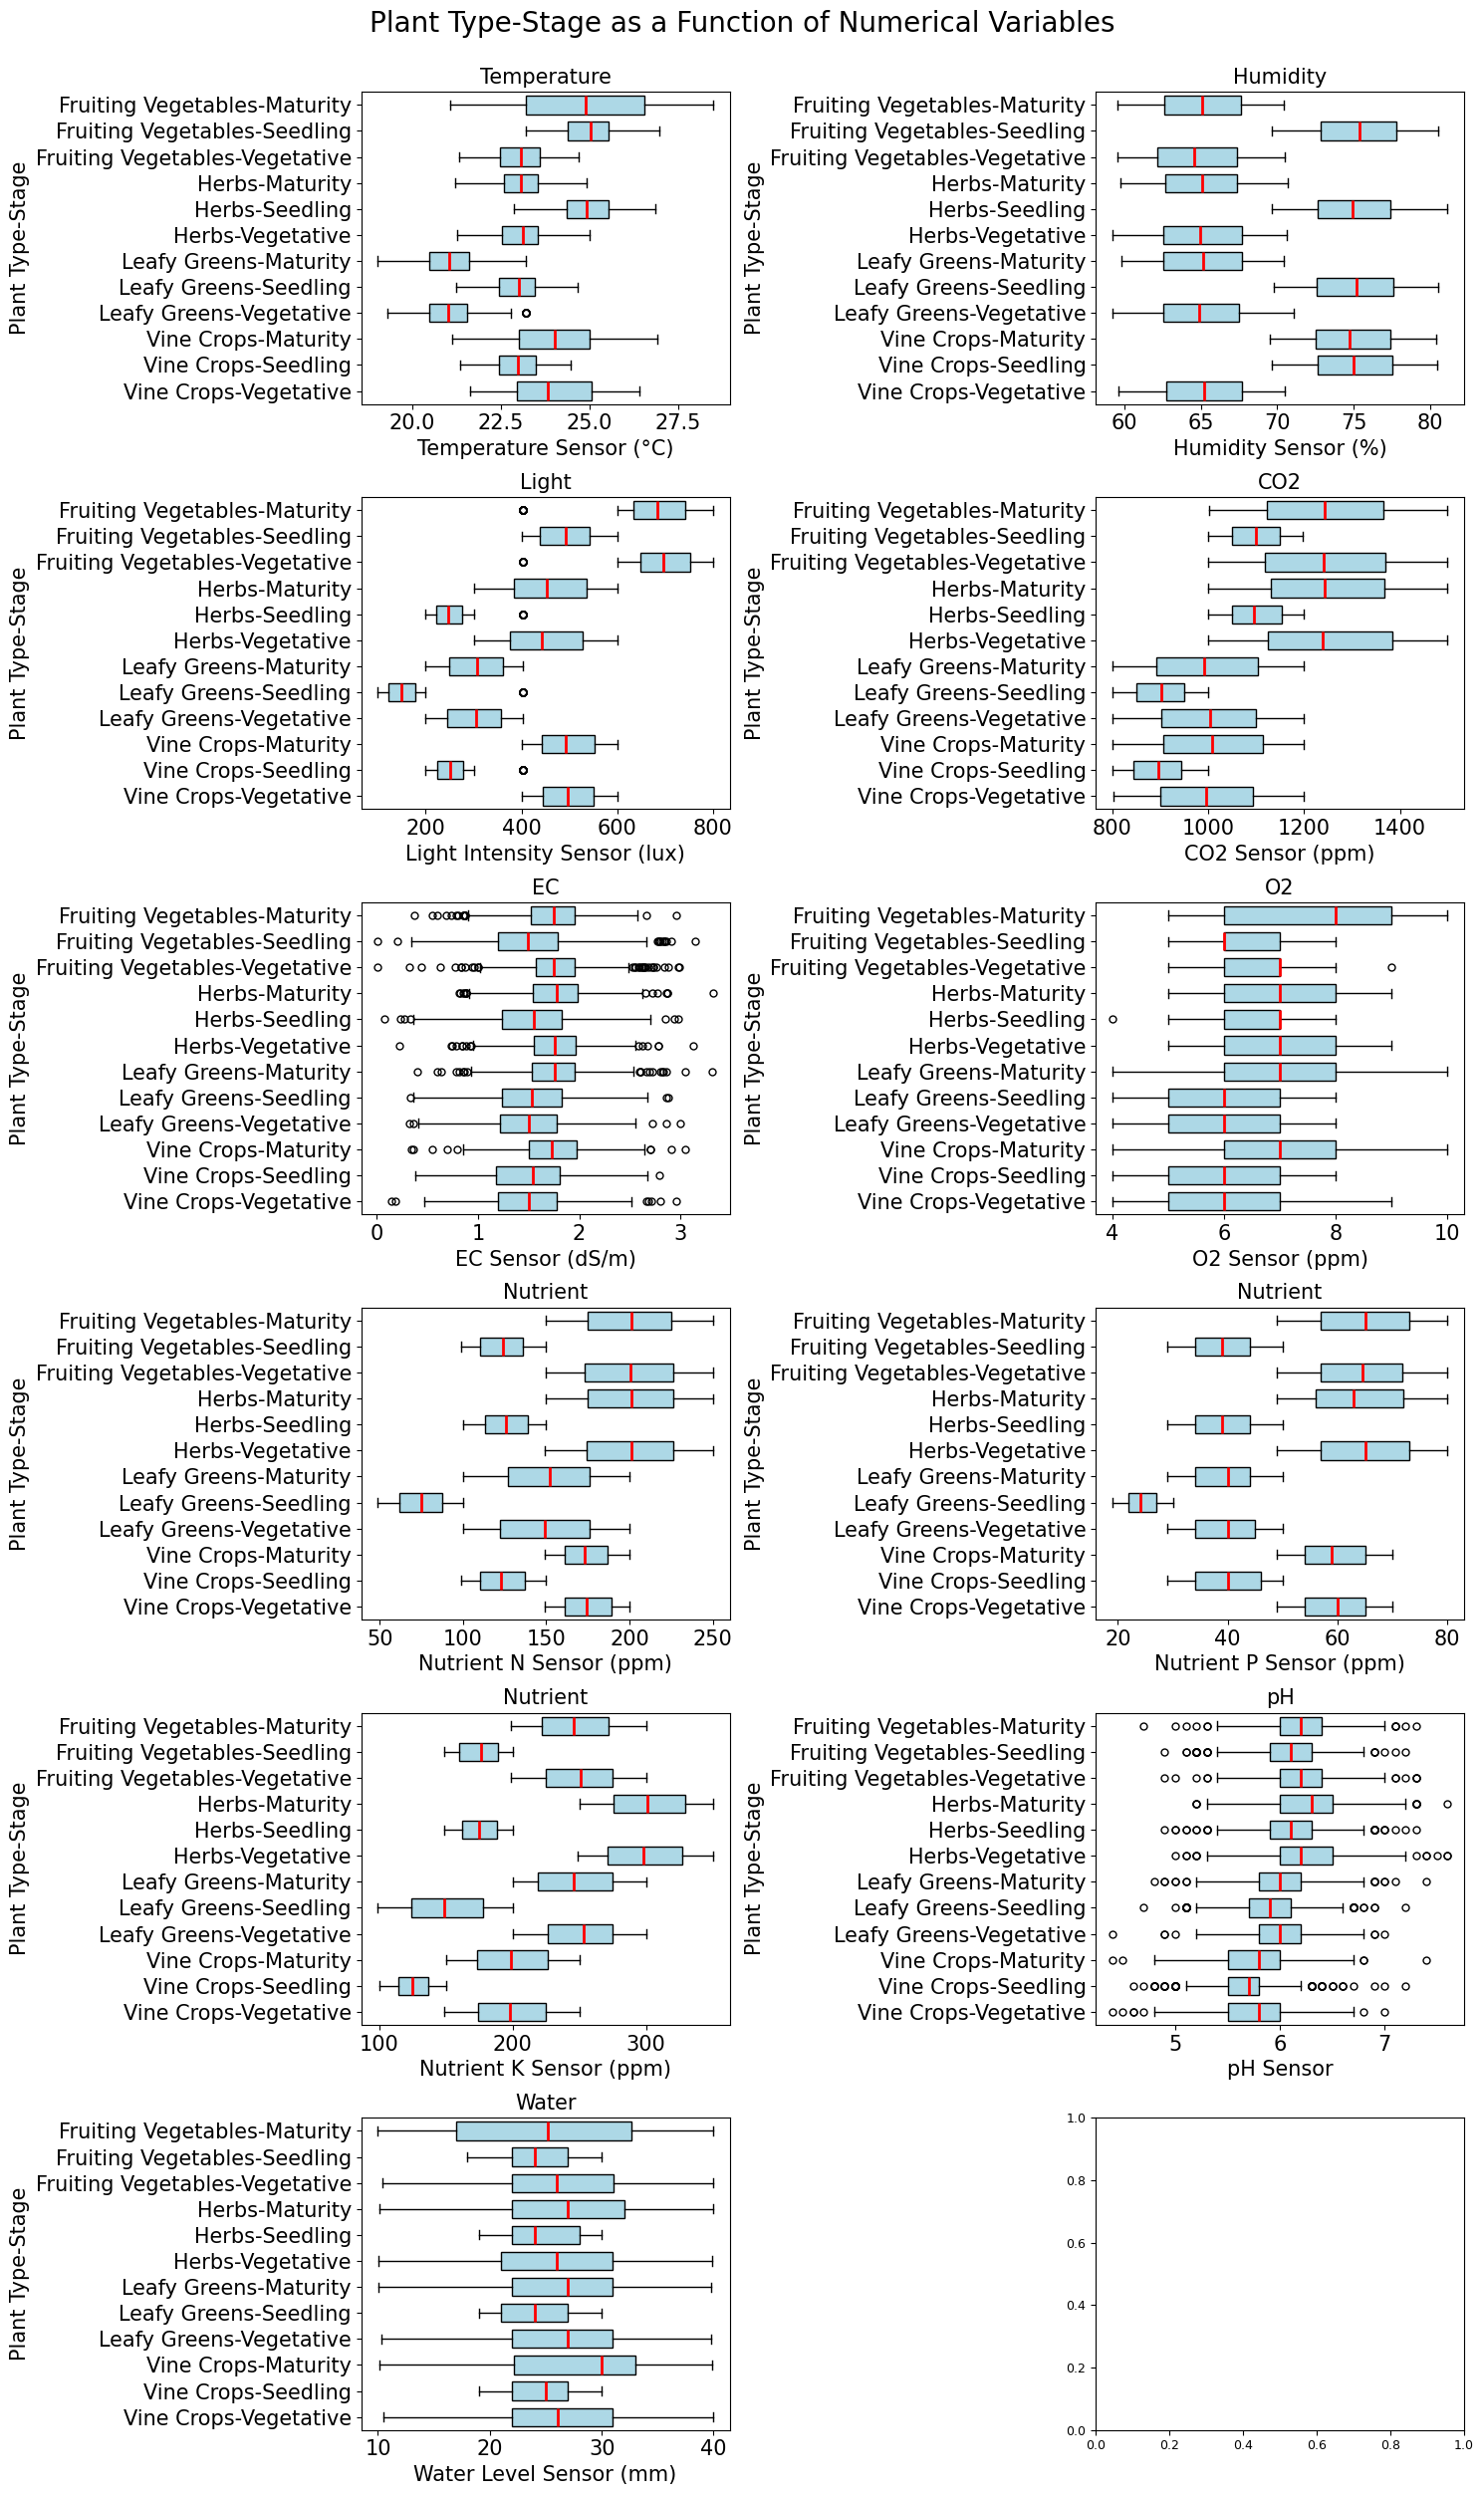

In [59]:
# Visualizing the relationship between Plant Type-Stage (Y) and other features(X).
fig, ax = plt.subplots(6,2, figsize=(15,25))

r, c = 0, 0

labels = agri['Plant Type-Stage'].unique().tolist()
labels.sort(reverse=True)

plt.style.use('default')

for f in agri.columns[4:-1]:
    X = []
    for l in labels:
        x = agri.loc[agri['Plant Type-Stage']==l][f]
        X.append(x)

    ax[r,c].boxplot(X, tick_labels=labels, patch_artist=True, medianprops={'linewidth':2, 'color':'red'}, 
                    boxprops={'facecolor':'lightblue'}, widths=0.7, flierprops={'markersize': 5}, vert=False)
    ax[r,c].set_ylabel('Plant Type-Stage', fontdict={'fontsize':15})
    ax[r,c].set_yticklabels(labels, fontsize=15)
    ax[r,c].set_xlabel(f, fontdict={'fontsize':15})
    ax[r,c].tick_params(axis='x', labelsize=15)
    ax[r,c].set_title(f.split()[0], fontdict={'fontsize':15})
    
    if c>0:
        r+=1
        c=0
    else:
        c+=1

plt.suptitle('Plant Type-Stage as a Function of Numerical Variables', fontsize=20, y=1) 
fig.tight_layout(h_pad=1)
plt.show()

Significant differential distribution of Plant Type-Stage classes across Temperature, Humidity, Light Intensity, CO2, Nutrient N, P and K are observed, based on the median, 25th, 75th percentiles and interquartile ranges. For example, lower humidity tends to favor vegetative stage for all plant types. Higher light intensity favors mature and seedling fruiting vegetables growth, while lower light intensity favors seedling herbs, seedling vine crop and leafy green of all stages. Medium light intensity is conducive for mature and vegetative herbs and vine crops, and seedling fruiting vegetables. Nutrient K seems to have the most discriminative power for the different Plant Type-Stage classes. Taken together, these observations suggest that knowing the values of these variables provide very useful information for predicting the plant type and stage that will best thrive.

**3.3.2 Categorical X variables**

In [62]:
# Create a table to get the counts of each class of Plant Type-Stage in each System Location.
location = cross_table(agri['System Location Code'], agri['Plant Type-Stage'])
location

Plant Type-Stage,Fruiting Vegetables-Maturity,Fruiting Vegetables-Seedling,Fruiting Vegetables-Vegetative,Herbs-Maturity,Herbs-Seedling,Herbs-Vegetative,Leafy Greens-Maturity,Leafy Greens-Seedling,Leafy Greens-Vegetative,Vine Crops-Maturity,...,Fruiting Vegetables-Vegetative(%),Herbs-Maturity(%),Herbs-Seedling(%),Herbs-Vegetative(%),Leafy Greens-Maturity(%),Leafy Greens-Seedling(%),Leafy Greens-Vegetative(%),Vine Crops-Maturity(%),Vine Crops-Seedling(%),Vine Crops-Vegetative(%)
System Location Code,,,,,,,,,,,,,,,,,,,,,
Zone_A,102,82,89,110,84,89,80,88,69,87,...,8.309991,10.270775,7.843137,8.309991,7.469655,8.216620,6.442577,8.123249,8.776844,9.056956
Zone_B,91,90,98,95,93,82,100,96,73,95,...,9.074074,8.796296,8.611111,7.592593,9.259259,8.888889,6.759259,8.796296,8.055556,7.407407
Zone_C,101,87,94,104,93,76,99,95,67,78,...,8.842897,9.783631,8.748824,7.149577,9.313264,8.936971,6.302916,7.337723,8.372531,7.525870
Zone_D,67,83,82,80,87,97,113,72,92,75,...,7.877041,7.684918,8.357349,9.317963,10.854947,6.916427,8.837656,7.204611,10.951009,7.588857
Zone_E,91,83,97,84,94,93,91,94,86,75,...,9.176916,7.947020,8.893094,8.798486,8.609272,8.893094,8.136235,7.095553,7.852412,8.136235
Zone_F,62,83,88,89,98,102,74,94,78,76,...,8.568647,8.666018,9.542356,9.931840,7.205453,9.152872,7.594937,7.400195,8.373905,9.444985
Zone_G,72,89,82,82,91,113,92,95,92,77,...,7.635009,7.635009,8.472998,10.521415,8.566108,8.845438,8.566108,7.169460,8.379888,9.217877


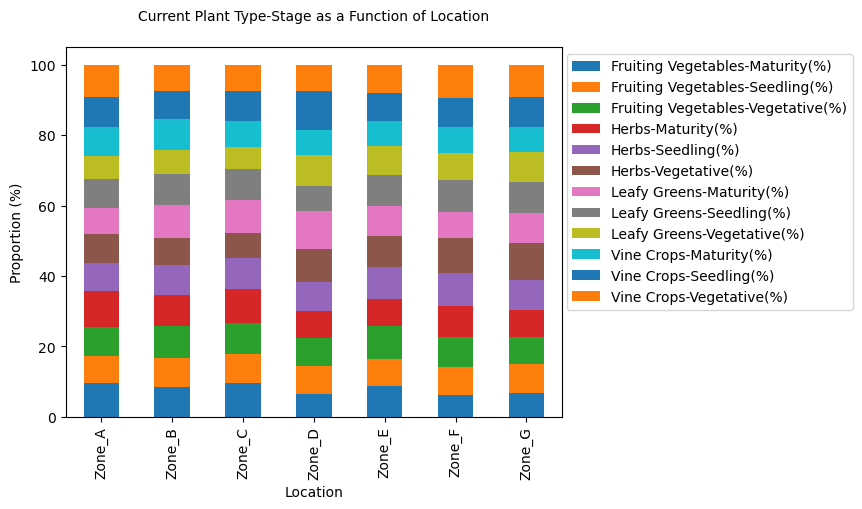

In [63]:
# Stacked barcharts to visualize the distribution of Plant Type-Stage classes across different System Location zones.
stackBar(location, 'Location', 'Proportion (%)', "Current Plant Type-Stage as a Function of Location", normalized=False)

In [64]:
# Chi Square test.
print(stats.chi2_contingency(location.iloc[:,0:12]))

Chi2ContingencyResult(statistic=82.52357985783634, pvalue=0.08225251729294597, dof=66, expected_freq=array([[84.66288952, 86.25212465, 91.01983003, 93.04249292, 92.46458924,
        94.19830028, 93.76487252, 91.59773371, 80.47308782, 81.33994334,
        92.898017  , 89.28611898],
       [85.37434237, 86.97693242, 91.78470255, 93.82436261, 93.24160259,
        94.98988264, 94.55281263, 92.36746257, 81.14933225, 82.02347228,
        93.6786726 , 90.0364225 ],
       [84.03048698, 85.60785107, 90.33994334, 92.34749764, 91.7739107 ,
        93.49467152, 93.06448132, 90.91353028, 79.87198165, 80.73236207,
        92.2041009 , 88.61918252],
       [82.29138001, 83.83609875, 88.47025496, 90.43626062, 89.87454472,
        91.55969243, 91.1384055 , 89.03197086, 78.2189397 , 79.06151356,
        90.29583165, 86.78510724],
       [83.55618508, 85.12464589, 89.83002833, 91.82625118, 91.25590179,
        92.96694995, 92.53918791, 90.40037771, 79.42115203, 80.27667611,
        91.68366383, 88.11898

In [65]:
# Create a table to get the counts of each class of Plant Type-Stage in each Previous Cycle Plant Type.
pre_plantType = cross_table(agri['Previous Cycle Plant Type'], agri['Plant Type-Stage'])
pre_plantType

Plant Type-Stage,Fruiting Vegetables-Maturity,Fruiting Vegetables-Seedling,Fruiting Vegetables-Vegetative,Herbs-Maturity,Herbs-Seedling,Herbs-Vegetative,Leafy Greens-Maturity,Leafy Greens-Seedling,Leafy Greens-Vegetative,Vine Crops-Maturity,...,Fruiting Vegetables-Vegetative(%),Herbs-Maturity(%),Herbs-Seedling(%),Herbs-Vegetative(%),Leafy Greens-Maturity(%),Leafy Greens-Seedling(%),Leafy Greens-Vegetative(%),Vine Crops-Maturity(%),Vine Crops-Seedling(%),Vine Crops-Vegetative(%)
Previous Cycle Plant Type,,,,,,,,,,,,,,,,,,,,,
Fruiting Vegetables,145,149,177,167,157,147,153,144,151,128,...,9.725275,9.175824,8.626374,8.076923,8.406593,7.912088,8.296703,7.032967,9.395604,7.197802
Herbs,170,137,148,148,161,169,160,172,139,145,...,8.004327,8.004327,8.707409,9.140076,8.653326,9.302326,7.517577,7.842077,8.545160,7.679827
Leafy Greens,154,159,158,150,166,171,162,169,122,126,...,8.462775,8.034280,8.891269,9.159079,8.677022,9.051955,6.534547,6.748795,8.730584,8.944831
Vine Crops,117,152,147,179,156,165,174,149,145,164,...,7.831646,9.536494,8.311135,8.790623,9.270112,7.938199,7.725093,8.737347,8.044752,9.483218


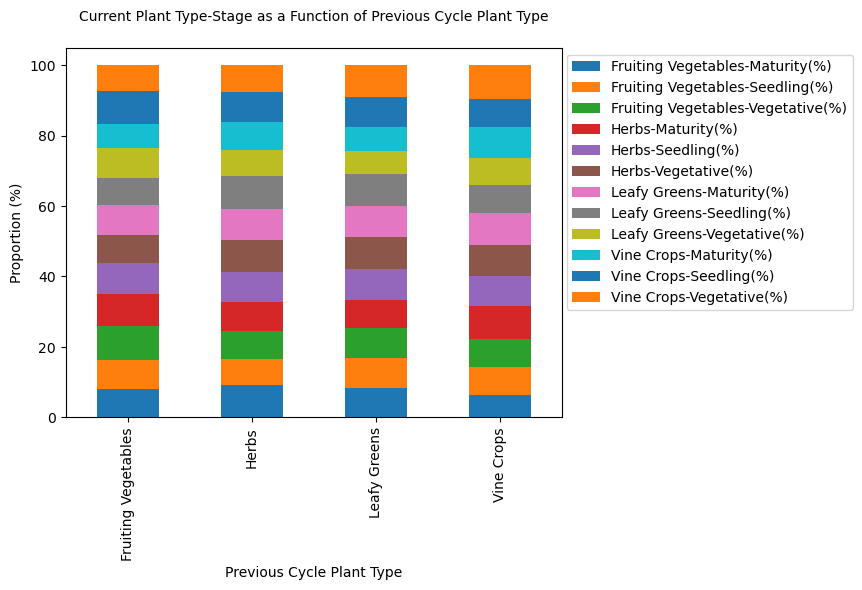

In [66]:
# Stacked barcharts to visualize the distribution of Plant Type-Stage classes across different Previous Cycle Plant Type.
stackBar(pre_plantType, 'Previous Cycle Plant Type', 'Proportion (%)', "Current Plant Type-Stage as a Function of Previous Cycle Plant Type", normalized=False)

In [67]:
# Chi Square test.
print(stats.chi2_contingency(pre_plantType.iloc[:,0:12]))

Chi2ContingencyResult(statistic=46.745666084001, pvalue=0.056917360885595375, dof=33, expected_freq=array([[143.87157696, 146.57223796, 154.67422096, 158.11142587,
        157.12936733, 160.07554297, 159.33899906, 155.65627951,
        136.7516525 , 138.22474032, 157.86591124, 151.72804533],
       [146.16403615, 148.90772966, 157.1388102 , 160.63078376,
        159.63307703, 162.62619722, 161.87791717, 158.13651693,
        138.93066235, 140.42722245, 160.38135708, 154.14569   ],
       [147.58694186, 150.3573452 , 158.66855524, 162.19452314,
        161.18710374, 164.20936193, 163.45379738, 159.67597464,
        140.28315122, 141.79428032, 161.94266829, 155.64629705],
       [148.37744503, 151.16268717, 159.5184136 , 163.06326723,
        162.05045191, 165.08889788, 164.32928639, 160.53122892,
        141.03453393, 142.55375691, 162.8100634 , 156.47996762]]))


To explore if there is a relationship between Plant Type-Stage and the 2 categorical variables, System Location and Previous Cycle Plant Type, stacked barchart is used to look at the proportions of different Plant Type-Stage classes in each of System Location and Previous Cycle Plant Type categories. Proportion, instead of raw counts, is plotted because the varying frequencies of the different categories of the 2 variables. It would be misleading to just look at the raw counts.

From the barchart, we can see that the proportions of the different Plant Type-Stage classes are very similar across the different categories of the 2 variables. Chi Square test quantitatively verified that there is no statistically significant difference (p-value > 0.05) in proportions of Plant Type-Stage classes across the  System Location and Previous Cycle Plant Type. This indicates that a predictive relationship between Plant Type-Stage and the 2 categorical variables doesn't exist.

**3.4 Relationship (if any) between Temperature (Y variable) and the other features (X variables)**

**3.4.1 Categorical X variables**

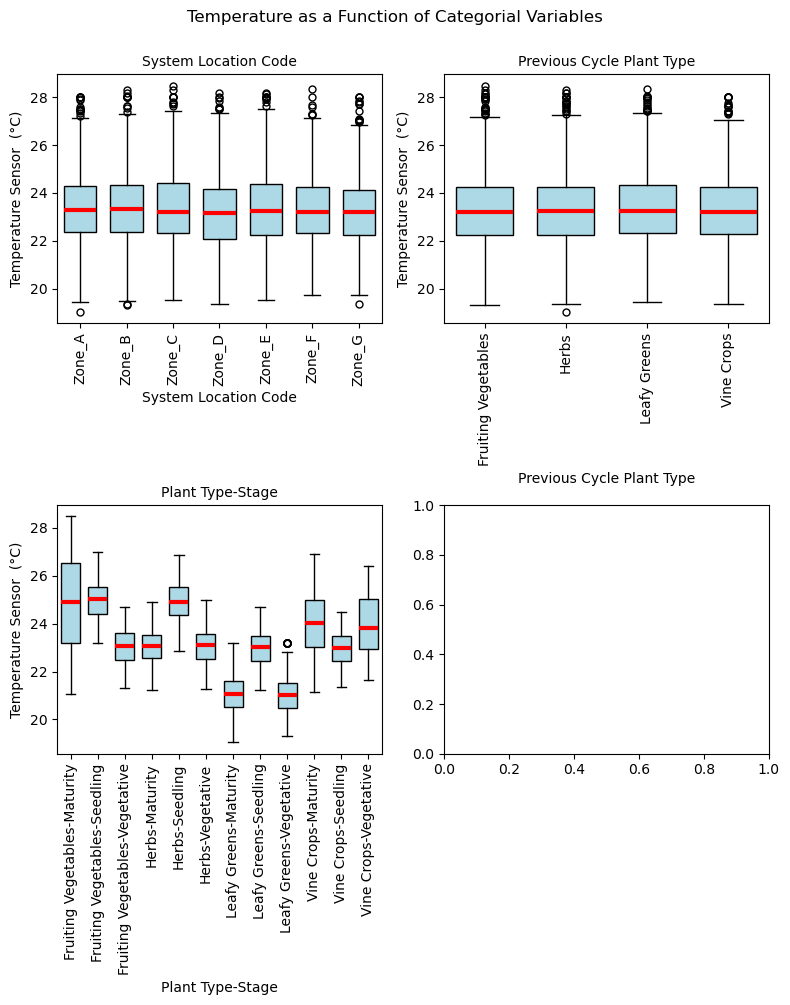

In [71]:
# Visualizing the relationship between Temperature(Y) and other features(X).
fig, ax = plt.subplots(2,2, figsize=(8,10))

r, c = 0, 0

plt.style.use('default')

for f in ['System Location Code','Previous Cycle Plant Type','Plant Type-Stage']:
    Y = []
    labels = agri[f].unique().tolist()
    labels.sort()
    for l in labels:
        y = agri.loc[agri[f]==l]['Temperature Sensor (°C)']
        Y.append(y)

    ax[r,c].boxplot(Y, tick_labels=labels, patch_artist=True, medianprops={'linewidth':3, 'color':'red'}, 
                    boxprops={'facecolor':'lightblue'}, widths=0.7, flierprops={'markersize': 5}, vert=True)
    ax[r,c].set_ylabel('Temperature Sensor  (°C)', fontdict={'fontsize':10})
    ax[r,c].set_xlabel(f, fontdict={'fontsize':10})
    ax[r,c].tick_params(axis='x', labelsize=10, rotation=90)
    ax[r,c].set_title(f, fontdict={'fontsize':10})

    if c>0:
        r+=1
        c=0
    else:
        c+=1

plt.suptitle('Temperature as a Function of Categorial Variables', fontsize=12, y=1) 
fig.tight_layout(h_pad=1)
plt.show()

No relationship is observed between Temperature and the 2 categorical variables, System Location and Previous Cycle Plant Type. Based on the median, 25th, 75th percentiles and interquartile ranges, the different catergories of System Location and Previous Cycle Plant Type are distributed over the same temperature range. This suggests that knowing the catergories of System Location or Previous Cycle Plant Type provide little information for predicting the likely temperature. However, the plant type and stage in the farm has predictive value for temperature. 

The relationship between Temperature and other numerical variables are contained in the correlation heatmap above. So it is not analysed again here.

In [73]:
# Export cleaned dataset to Excel file.
# agri.to_excel('cleaned_table.xlsx', index=False)